In [1]:
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load train, test, items, item_categories, shops files.

In [2]:
train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv')
items_df = pd.read_csv('items.csv')
item_cat_df = pd.read_csv('item_categories.csv')
shops_df = pd.read_csv('shops.csv')

### Data analysis

In [3]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [4]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In training data, we have negative item_price and negative item_cnt_day. We should investigate those values.

In [5]:
# check negative item_price
negative_prices = train_data[train_data['item_price'] <= 0].reset_index(drop=True)
print(negative_prices)
print(len(negative_prices))

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  15.05.2013               4       32     2973        -1.0           1.0   

   item_category_id  
0                19  
1


There is only 1 negative item_price, not too many rows so we can remove this record.

In [6]:
train_data = train_data[train_data['item_price'] > 0].reset_index(drop=True)

In [7]:
# check negative item_cnt_day
negative_item_cnt = train_data[train_data['item_cnt_day'] < 0].reset_index(drop=True)
print(negative_item_cnt)
print(len(negative_item_cnt))

            date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0     05.01.2013               0       25     2552       899.0          -1.0   
1     23.01.2013               0       25     2321       999.0          -1.0   
2     07.01.2013               0       25     2199      1449.0          -1.0   
3     02.01.2013               0       25     2330       599.0          -1.0   
4     13.01.2013               0       25     5034      1989.0          -1.0   
...          ...             ...      ...      ...         ...           ...   
7351  26.10.2015              33       25     3917       449.0          -1.0   
7352  18.10.2015              33       25     4896      6398.0          -1.0   
7353  05.10.2015              33       25    10039       249.0          -1.0   
7354  16.10.2015              33       25     7893      2990.0          -1.0   
7355  07.10.2015              33       25     7087       999.0          -1.0   

      item_category_id  
0             

There are lots of row with negative item_cnt_day, so we can not delete all of them. We can replace -1 with 0 as there is no sell at those days.

In [8]:
train_data.loc[train_data['item_cnt_day'] < 0, 'item_cnt_day'] = 0

We should change datetime to dd/mm/yyyy

In [9]:
train_data['date'] = pd.to_datetime(train_data['date'], format='%d.%m.%Y')

We should check outliers in item_price and item_cnt_day.

<Axes: ylabel='item_cnt_day'>

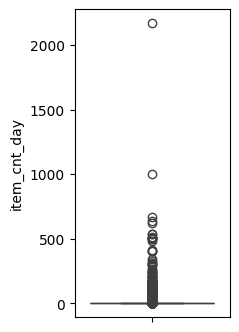

In [10]:
plt.figure(figsize = (2,4))
sns.boxplot(y = train_data.item_cnt_day)

We can see that there are outliers in this feature. We can remove records which item_cnt_day is greater than 1000.

In [11]:
print('num of item_cnt_day >= 1000: ', len(train_data[train_data['item_cnt_day'] >= 1000]))
print(train_data[train_data['item_cnt_day'] >= 1000])

num of item_cnt_day >= 1000:  2
              date  date_block_num  shop_id  item_id  item_price  \
2326929 2015-01-15              24       12    20949    4.000000   
2909817 2015-10-28              33       12    11373    0.908714   

         item_cnt_day  item_category_id  
2326929        1000.0                71  
2909817        2169.0                 9  


There are 2 outliers of item_cnt_day. We can remove those.

In [12]:
train_data = train_data[(train_data['item_cnt_day'] < 1000)]

<Axes: ylabel='item_price'>

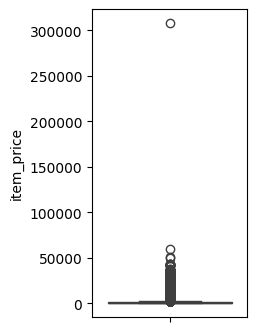

In [13]:
plt.figure(figsize = (2,4))
sns.boxplot(y = train_data.item_price)

We can see that there are outliers in this feature. We can remove records which item_price is greater than 300000. Is this shop sell house?

In [14]:
print('num of item_price >= 300000: ', len(train_data[train_data['item_price'] >= 300000]))
print(train_data[train_data['item_price'] >= 300000])

num of item_price >= 300000:  1
              date  date_block_num  shop_id  item_id  item_price  \
1163157 2013-12-13              11       12     6066    307980.0   

         item_cnt_day  item_category_id  
1163157           1.0                75  


There are 1 outlier of item_price. We can remove this.

In [15]:
train_data = train_data[train_data['item_price'] < 300000]

We will check the test file.

In [16]:
test_data.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0
1,1,5,5320,0
2,2,5,5233,0
3,3,5,5232,0
4,4,5,5268,0


In [17]:
print('number of item_id in test set', len(test_data['item_id'].unique()))
test_item_id = set(test_data['item_id'].unique())
train_item_id = set(train_data['item_id'].unique())
print('number of new item_id in test set', len(test_item_id - train_item_id))
train_last_month_cnt_item = train_data[train_data['date_block_num'] == 33].groupby(['item_id', 'shop_id'])['item_cnt_day'].sum().reset_index()
train_last_month_cnt_item.columns = ['item_id', 'shop_id', 'last_month_cnt_item']
test_item_id_df = test_data.merge(train_last_month_cnt_item, on=['item_id', 'shop_id'], how='left')
test_item_id_df.fillna(0, inplace=True)
print('number of item_id in shop_id in test set which have last_month_cnt_item = 0 is', len(test_item_id_df[test_item_id_df['last_month_cnt_item'] == 0]))
print('number of item_id in shop_id in test set', len(test_data))
print('percentage of item_cnt_month = 0:', 100*len(test_item_id_df[test_item_id_df['last_month_cnt_item'] == 0])/len(test_data))

number of item_id in test set 5100
number of new item_id in test set 363
number of item_id in shop_id in test set which have last_month_cnt_item = 0 is 185528
number of item_id in shop_id in test set 214200
percentage of item_cnt_month = 0: 86.61437908496733


In the test set, there are 363 new items. And with the tuple (shop_id, item_id), the last month with date_block_num = 33 has 185528 items in shop which has item_cnt as 0, about 87% of the test set. I think that most products have a sales quantity of 0 in the test set.

In [18]:
index_cols = ['date_block_num', 'shop_id', 'item_id']

percentage of item_cnt_month = 0 of original training data: 0.03106431027523592
original training data with item_cnt_month


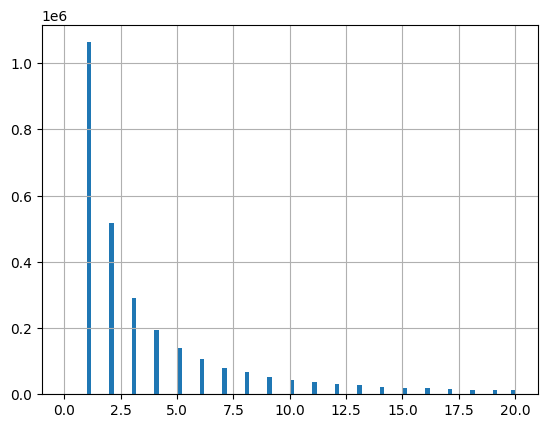

percentage of item_cnt_month = 0 of processed training data: 85.26431297465119
processed training data with item_cnt_month


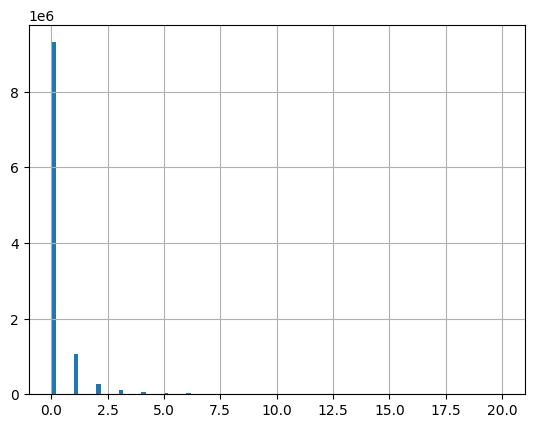

In [19]:
original_train_data_item_cnt_month_group = train_data.groupby(index_cols)['item_cnt_day'].sum().reset_index()
original_train_data_item_cnt_month_group.columns = index_cols + ['item_cnt_month']
original_train_data_item_cnt_month = pd.merge(train_data, original_train_data_item_cnt_month_group, on=index_cols, how='left')
original_train_data_item_cnt_month.fillna({'item_cnt_month':0},inplace=True)
original_train_data_item_cnt_month['item_cnt_month'].hist(bins=100, range=(0, 20))
print('percentage of item_cnt_month = 0 of original training data:', 
      100*len(original_train_data_item_cnt_month[original_train_data_item_cnt_month['item_cnt_month'] == 0])/len(original_train_data_item_cnt_month))
print('original training data with item_cnt_month')
plt.show()
all_shop_item_cnt_month = []
for i in range(34):
    sales = train_data[train_data['date_block_num']==i]
    all_shop_item_cnt_month.append(np.array(list(product([i],sales['shop_id'].unique(),sales['item_id'].unique())), dtype=np.int16))
all_shop_item_cnt_month = pd.DataFrame(data=np.vstack(all_shop_item_cnt_month), columns=index_cols)
all_shop_item_cnt_month.sort_values(index_cols, inplace=True)
all_shop_item_cnt_month.reset_index(drop=True, inplace=True)
all_shop_item_cnt_month = pd.merge(all_shop_item_cnt_month, original_train_data_item_cnt_month_group, on=index_cols, how='left')
all_shop_item_cnt_month.fillna({'item_cnt_month':0},inplace=True)
all_shop_item_cnt_month['item_cnt_month'].hist(bins=100, range=(0, 20))
print('percentage of item_cnt_month = 0 of processed training data:', 
      100*len(all_shop_item_cnt_month[all_shop_item_cnt_month['item_cnt_month'] == 0])/len(all_shop_item_cnt_month))
print('processed training data with item_cnt_month')
plt.show()

In the original training dataset, the proportion of products with monthly sales equal to 0 is very low because unsold products in stores are not recorded. However, when we process the dataset, if a product is sold in any shop during that month, we will add the sales quantity for that product across all shops in that month. This way, the new training dataset will fully represent the number of products sold in each shop, and the proportion of unsold products in each shop becomes more similar to the test set (85% in processed train set and 87% in test set).

Item_categories, items, shops are just mapping values, we do not need to analysis those files.

In [20]:
del negative_item_cnt, train_last_month_cnt_item, test_item_id_df, original_train_data_item_cnt_month_group, original_train_data_item_cnt_month, all_shop_item_cnt_month


### Data processing

Create processed training data

In [21]:
train_data.sort_values(by=index_cols, inplace=True)
item_cnt_month_group = train_data.groupby(index_cols)['item_cnt_day'].sum().reset_index()
item_cnt_month_group.columns = index_cols + ['item_cnt_month']

all_shop_train_data = []
for i in range(34):
    sales = train_data[train_data['date_block_num']==i]
    all_shop_train_data.append(np.array(list(product([i],sales['shop_id'].unique(),sales['item_id'].unique())), dtype=np.int16))
all_shop_train_data = pd.DataFrame(data=np.vstack(all_shop_train_data), columns=index_cols)
all_shop_train_data.sort_values(index_cols, inplace=True)
all_shop_train_data.reset_index(drop=True, inplace=True)
all_shop_train_data = pd.merge(all_shop_train_data, item_cnt_month_group, on=index_cols, how='left')
all_shop_train_data.fillna({'item_cnt_month':0},inplace=True)

Merge test data for feature engineering

In [22]:
test_data['date_block_num'] = 34
test_data.drop(columns='ID',inplace=True)
full_data = pd.concat([all_shop_train_data, test_data]).copy()
full_data = full_data.reset_index(drop=True)
full_data.fillna({'item_cnt_month':0},inplace=True)

Merge with items file for item categories

In [23]:
full_data = pd.merge(full_data, items_df, on='item_id', how='left')
full_data

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,19,0.0,40
1,0,0,27,0.0,19
2,0,0,28,0.0,30
3,0,0,29,0.0,23
4,0,0,32,6.0,40
...,...,...,...,...,...
11127999,34,45,18454,0.0,55
11128000,34,45,16188,0.0,64
11128001,34,45,15757,0.0,55
11128002,34,45,19648,0.0,40


In [24]:
lag_features = []
drop_features = []

The average number of products sold by month.

In [25]:
group_item_id_by_month = full_data.groupby(['date_block_num', 'item_id'])['item_cnt_month'].aggregate(['mean'])
group_item_id_by_month.columns = ['cnt_item_id_by_month']
group_item_id_by_month.reset_index(inplace=True)
full_data = pd.merge(full_data, group_item_id_by_month, on=['date_block_num','item_id'], how='left')
full_data['cnt_item_id_by_month'] = full_data['cnt_item_id_by_month'].astype('float16')
lag_features += ['cnt_item_id_by_month']
drop_features += ['cnt_item_id_by_month']
del group_item_id_by_month

The average number of products a shop sold by month

In [26]:
group_shop_by_month = full_data.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].aggregate(['mean'])
group_shop_by_month.columns = ['cnt_shop_id_by_month']
group_shop_by_month.reset_index(inplace=True)
full_data = pd.merge(full_data, group_shop_by_month, on=['date_block_num','shop_id'], how='left')
full_data['cnt_shop_id_by_month'] = full_data['cnt_shop_id_by_month'].astype('float16')
lag_features += ['cnt_shop_id_by_month']
drop_features += ['cnt_shop_id_by_month']
del group_shop_by_month

The average number of products sold by category each month

In [27]:
group_item_category_by_month = full_data.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].aggregate(['mean'])
group_item_category_by_month.columns = ['cnt_item_category_by_month']
group_item_category_by_month.reset_index(inplace=True)
full_data = pd.merge(full_data, group_item_category_by_month, on=['date_block_num','item_category_id'], how='left')
full_data['cnt_item_category_by_month'] = full_data['cnt_item_category_by_month'].astype('float16')
lag_features += ['cnt_item_category_by_month']
drop_features += ['cnt_item_category_by_month']
del group_item_category_by_month

The average number of products sold by category at shop each month

In [28]:
group_item_category_by_shop_id_month = full_data.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].aggregate(['mean'])
group_item_category_by_shop_id_month.columns = ['cnt_item_category_by_shop_id_month']
group_item_category_by_shop_id_month.reset_index(inplace=True)
full_data = pd.merge(full_data, group_item_category_by_shop_id_month, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
full_data['cnt_item_category_by_shop_id_month'] = full_data['cnt_item_category_by_shop_id_month'].astype('float16')
lag_features += ['cnt_item_category_by_shop_id_month']
drop_features += ['cnt_item_category_by_shop_id_month']
del group_item_category_by_shop_id_month

The average number of products sold by id at shop each month

In [29]:
group_item_category_by_shop_id_month = full_data.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_month'].aggregate(['mean'])
group_item_category_by_shop_id_month.columns = ['cnt_item_id_by_shop_id_month']
group_item_category_by_shop_id_month.reset_index(inplace=True)
full_data = pd.merge(full_data, group_item_category_by_shop_id_month, on=['date_block_num', 'shop_id', 'item_id'], how='left')
full_data['cnt_item_id_by_shop_id_month'] = full_data['cnt_item_id_by_shop_id_month'].astype('float16')
lag_features += ['cnt_item_id_by_shop_id_month']
drop_features += ['cnt_item_id_by_shop_id_month']
del group_item_category_by_shop_id_month

The average price of products in a shop each month

In [30]:
group_price_mean = train_data.groupby(index_cols)['item_price'].aggregate(['mean'])
group_price_mean.columns = ['item_price_mean']
group_price_mean.reset_index(inplace=True)
full_data = pd.merge(full_data, group_price_mean, on=index_cols, how='left')
full_data['item_price_mean'] = full_data['item_price_mean'].astype('float16')
drop_features += ['item_price_mean']
del group_price_mean

Price of the first month of products in a shop each month

In [31]:
group_price_mean = train_data.groupby(index_cols)['item_price'].aggregate(['mean'])
group_price_mean.columns = ['item_price_mean']
group_price_mean.reset_index(inplace=True)
group_price_mean.sort_values(by='date_block_num', inplace=True)
first_price_per_item = group_price_mean.groupby(['shop_id', 'item_id'])['item_price_mean'].aggregate(['first'])
first_price_per_item.columns = ['first_item_price_mean']
first_price_per_item.reset_index(inplace=True)
full_data = pd.merge(full_data, first_price_per_item, on=['shop_id', 'item_id'], how='left')
full_data['first_item_price_mean'] = full_data['first_item_price_mean'].astype('float16')
drop_features += ['first_item_price_mean']
del group_price_mean, first_price_per_item

Add z_item_price feature

In [32]:
full_data['z_item_price_mean'] = full_data['item_price_mean'] / full_data['first_item_price_mean'] - 1.0
full_data['z_item_price_mean'] = full_data['z_item_price_mean'].fillna(0)
full_data['z_item_price_mean'] = full_data['z_item_price_mean'].astype('float16')
lag_features += ['z_item_price_mean']
drop_features += ['z_item_price_mean']

Add lag features

In [33]:
lag_frame = [i+1 for i in range(3)]
def create_lag_feature(df, lags, features):
    for feature in features:
        print(feature)
        for lag in lags:
            shifted = df[index_cols + [feature]].copy()
            shifted.columns = index_cols + [f'{feature}_lag_{lag}']
            shifted['date_block_num'] = shifted['date_block_num'] + lag
            df = pd.merge(df, shifted, on=index_cols, how='left')
    return df

In [34]:
print(lag_features)
print(drop_features)
full_data = create_lag_feature(full_data, lags=lag_frame, features=lag_features)
full_data

['cnt_item_id_by_month', 'cnt_shop_id_by_month', 'cnt_item_category_by_month', 'cnt_item_category_by_shop_id_month', 'cnt_item_id_by_shop_id_month', 'z_item_price_mean']
['cnt_item_id_by_month', 'cnt_shop_id_by_month', 'cnt_item_category_by_month', 'cnt_item_category_by_shop_id_month', 'cnt_item_id_by_shop_id_month', 'item_price_mean', 'first_item_price_mean', 'z_item_price_mean']
cnt_item_id_by_month
cnt_shop_id_by_month
cnt_item_category_by_month
cnt_item_category_by_shop_id_month
cnt_item_id_by_shop_id_month
z_item_price_mean


/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,cnt_item_id_by_month,cnt_shop_id_by_month,cnt_item_category_by_month,cnt_item_category_by_shop_id_month,cnt_item_id_by_shop_id_month,...,cnt_item_category_by_month_lag_3,cnt_item_category_by_shop_id_month_lag_1,cnt_item_category_by_shop_id_month_lag_2,cnt_item_category_by_shop_id_month_lag_3,cnt_item_id_by_shop_id_month_lag_1,cnt_item_id_by_shop_id_month_lag_2,cnt_item_id_by_shop_id_month_lag_3,z_item_price_mean_lag_1,z_item_price_mean_lag_2,z_item_price_mean_lag_3
0,0,0,19,0.0,40,0.022217,0.687500,0.311279,0.767578,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,19,0.155518,0.687500,0.853516,1.467773,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,30,0.177734,0.687500,1.192383,1.833984,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,23,0.111084,0.687500,0.551758,1.541992,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,40,6.644531,0.687500,0.311279,0.767578,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,55,0.000000,0.013924,0.004395,0.000000,0.0,...,0.217407,0.126831,0.074524,0.106079,1.0,0.0,0.0,-0.502441,0.0,0.0
11128000,34,45,16188,0.0,64,0.000000,0.013924,0.001116,0.000000,0.0,...,NaN,0.094482,0.117126,NaN,0.0,0.0,NaN,0.000000,0.0,NaN
11128001,34,45,15757,0.0,55,0.000000,0.013924,0.004395,0.000000,0.0,...,0.217407,0.126831,0.074524,0.106079,0.0,0.0,0.0,0.000000,0.0,0.0
11128002,34,45,19648,0.0,40,0.000000,0.013924,0.011375,0.000000,0.0,...,0.243774,0.083740,0.074097,0.111633,0.0,0.0,0.0,0.000000,0.0,0.0


Add month feature and change item_id, category_id, shop_id, month, date_num_block to category type

In [35]:
full_data['month'] = full_data['date_block_num'] % 12 + 1
full_data['shop_id'].astype("category")
full_data['item_id'].astype("category")
full_data['item_category_id'].astype("category")
full_data['month'].astype("category")
full_data['date_block_num'].astype("category")

0            0
1            0
2            0
3            0
4            0
            ..
11127999    34
11128000    34
11128001    34
11128002    34
11128003    34
Name: date_block_num, Length: 11128004, dtype: category
Categories (35, int64): [0, 1, 2, 3, ..., 31, 32, 33, 34]

Drop features and fillna

In [36]:
print(drop_features)
full_data.drop(drop_features, axis=1, inplace=True)
full_data.fillna(0, inplace=True)

['cnt_item_id_by_month', 'cnt_shop_id_by_month', 'cnt_item_category_by_month', 'cnt_item_category_by_shop_id_month', 'cnt_item_id_by_shop_id_month', 'item_price_mean', 'first_item_price_mean', 'z_item_price_mean']


Check all features

In [37]:
features = ['date_block_num', 'month', 'shop_id', 'item_id', 'item_category_id']
features += [f'{lag_feature}_lag_{i}' for lag_feature in lag_features for i in lag_frame]
features

['date_block_num',
 'month',
 'shop_id',
 'item_id',
 'item_category_id',
 'cnt_item_id_by_month_lag_1',
 'cnt_item_id_by_month_lag_2',
 'cnt_item_id_by_month_lag_3',
 'cnt_shop_id_by_month_lag_1',
 'cnt_shop_id_by_month_lag_2',
 'cnt_shop_id_by_month_lag_3',
 'cnt_item_category_by_month_lag_1',
 'cnt_item_category_by_month_lag_2',
 'cnt_item_category_by_month_lag_3',
 'cnt_item_category_by_shop_id_month_lag_1',
 'cnt_item_category_by_shop_id_month_lag_2',
 'cnt_item_category_by_shop_id_month_lag_3',
 'cnt_item_id_by_shop_id_month_lag_1',
 'cnt_item_id_by_shop_id_month_lag_2',
 'cnt_item_id_by_shop_id_month_lag_3',
 'z_item_price_mean_lag_1',
 'z_item_price_mean_lag_2',
 'z_item_price_mean_lag_3']

### Training

We will split the dataset, using cross validation for hyperparameter tuning with ramdomize search. The last model is used for evaluation and test prediction.

Train data from start to block 32, val data is block 33 and test data for block 34 prediction.

In [38]:
train_X = full_data[(full_data['date_block_num']<33)&(full_data['date_block_num']>len(lag_frame))][features]
train_Y = full_data[(full_data['date_block_num']<33)&(full_data['date_block_num']>len(lag_frame))]['item_cnt_month']

val_X = full_data[full_data['date_block_num']==33][features]
val_Y = full_data[full_data['date_block_num']==33]['item_cnt_month']

test_X = full_data[full_data['date_block_num']==34][features]

In [39]:
del full_data, train_data, all_shop_train_data
print(len(train_X), len(val_X), len(test_X))

9178167 238172 214200


In [40]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
from scipy.stats import randint, uniform, loguniform

Create cross validation training data

In [41]:
cross_validation = TimeSeriesSplit(n_splits=5)

Search the best param using RandomizedSearchCV for XGBRegressor

In [42]:
param_dis = {
    'n_estimators': np.arange(50, 450, 100),
    'max_depth': randint(3, 7),
    'learning_rate': np.array([1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]),
    'reg_lambda': uniform(0.1, 2),
    'subsample': uniform(0.5, 0.5),
    'eval_metric': ['rmse'],
    'colsample_bytree': uniform(0.5, 0.5),
    'max_bin': randint(256, 768),
    'nthread': [1],
    'device': ['gpu'],
    'enable_categorical': [True],
}
search_param = RandomizedSearchCV(XGBRegressor(), param_dis, 
                            n_iter=40, refit=True,
                            scoring = 'neg_root_mean_squared_error',
                            cv=cross_validation, verbose=3, n_jobs=5)

In [43]:
cp.cuda.Device(0).use()
X_train_gpu, y_train_gpu = cp.array(train_X).get(), cp.array(train_Y).get()
search_param.fit(X_train_gpu, y_train_gpu)
params_df = pd.DataFrame(search_param.cv_results_)
params_df.to_csv('params.csv')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.7070885730219072, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.003, max_bin=758, max_depth=6, n_estimators=150, nthread=1, reg_lambda=1.7349076500952212, subsample=0.7482223770422871;, score=-3.410 total time=   6.9s


/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.7070885730219072, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.003, max_bin=758, max_depth=6, n_estimators=150, nthread=1, reg_lambda=1.7349076500952212, subsample=0.7482223770422871;, score=-2.353 total time=  10.7s
[CV 1/5] END colsample_bytree=0.7332214831071802, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.3, max_bin=604, max_depth=6, n_estimators=50, nthread=1, reg_lambda=0.23657626446788385, subsample=0.5372710843741004;, score=-2.822 total time=   6.1s


/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.7070885730219072, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.003, max_bin=758, max_depth=6, n_estimators=150, nthread=1, reg_lambda=1.7349076500952212, subsample=0.7482223770422871;, score=-2.408 total time=  16.7s
[CV 2/5] END colsample_bytree=0.7332214831071802, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.3, max_bin=604, max_depth=6, n_estimators=50, nthread=1, reg_lambda=0.23657626446788385, subsample=0.5372710843741004;, score=-2.327 total time=  10.5s


/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.7070885730219072, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.003, max_bin=758, max_depth=6, n_estimators=150, nthread=1, reg_lambda=1.7349076500952212, subsample=0.7482223770422871;, score=-3.306 total time=  22.9s


/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.7332214831071802, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.3, max_bin=604, max_depth=6, n_estimators=50, nthread=1, reg_lambda=0.23657626446788385, subsample=0.5372710843741004;, score=-2.015 total time=  13.2s
[CV 5/5] END colsample_bytree=0.7070885730219072, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.003, max_bin=758, max_depth=6, n_estimators=150, nthread=1, reg_lambda=1.7349076500952212, subsample=0.7482223770422871;, score=-3.640 total time=  26.2s
[CV 4/5] END colsample_bytree=0.7332214831071802, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.3, max_bin=604, max_depth=6, n_estimators=50, nthread=1, reg_lambda=0.23657626446788385, subsample=0.5372710843741004;, score=-2.713 total time=  14.2s
[CV 1/5] END colsample_bytree=0.6104940330637568, device=gpu, enable_categorical=True, eval_metric=rmse, learning_rate=0.3, max_bin=692, max_depth=6, n_estimators=250, nthread=1, 

Model's best param and best score

In [44]:
print(search_param.best_params_)
print(search_param.best_score_)

{'colsample_bytree': np.float64(0.7502054410654428), 'device': 'gpu', 'enable_categorical': True, 'eval_metric': 'rmse', 'learning_rate': np.float64(0.01), 'max_bin': 620, 'max_depth': 3, 'n_estimators': np.int64(350), 'nthread': 1, 'reg_lambda': np.float64(0.625650240649613), 'subsample': np.float64(0.9815879277600021)}
-2.54263258976136


Training 10 best models using validation dataset.

In [45]:
average_train_score = []
average_val_score = []
model_lst = []
for i in range(1, 11):
    param = params_df[params_df['rank_test_score']==i]['params'].values[0]
    xgboost_model = XGBRegressor(**param, early_stopping_rounds=40)
    eval_set = (val_X, val_Y)
    model = xgboost_model.fit(train_X, train_Y, eval_set=[eval_set], verbose=False)
    train_preds = model.predict(train_X)
    val_preds = model.predict(val_X)
    train_score = root_mean_squared_error(train_Y, np.clip(train_preds, 0, None).astype(np.int64))
    val_score = root_mean_squared_error(val_Y, np.clip(val_preds, 0, None).astype(np.int64))
    print(train_score, val_score)
    average_train_score.append(train_score)
    average_val_score.append(val_score)
    model_lst.append(model)
print('Average RMSE:', sum(average_train_score)/len(average_train_score), sum(average_val_score)/len(average_val_score))

/home/cutia/anaconda3/envs/datanest/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:54:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


2.3782749877143776 1.9232170752446724
2.3092797774953446 1.9012128890766158
2.3045310538753556 2.101137804834288
2.385559529995967 1.9150709122892686
2.4299109671186976 2.0449863894625344
2.508500304688142 1.9627426727727284
2.403247273715523 1.8838172091340912
2.3808781061710067 2.0029955901084557
2.7336078950660925 1.9752256962342145
2.4700196282161064 2.150098548759278
Average RMSE: 2.4303809524056614 1.986050478791615


### Validation

The model has the average RMSE on train as 2.43 and 1.99 on test. The best model is 7th one.

The feature importance of the best model. The item_cnt_month features of previous months have the most impact to model accuracy.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

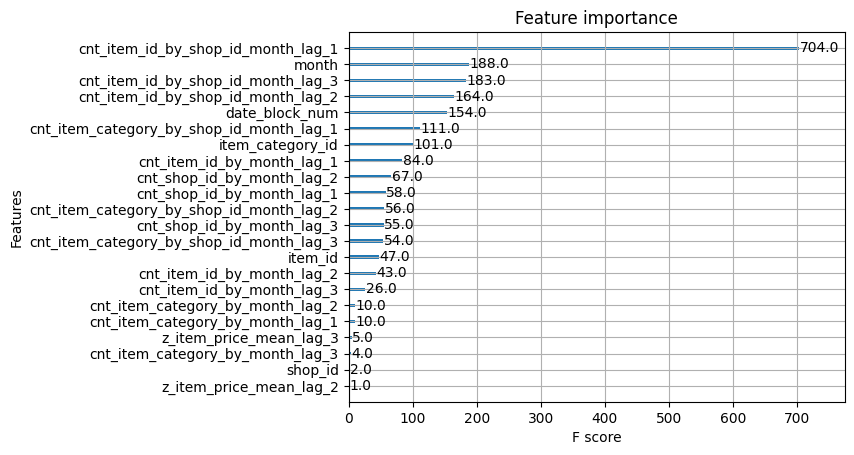

In [46]:
plot_importance(model_lst[0])

Update the predictions from the best models for the test set.

In [47]:
new_test_data = pd.read_csv('test.csv', index_col='ID')
test_lst = []
for i, model in enumerate(model_lst):
    test_preds = model.predict(test_X)
    test_preds = np.clip(test_preds, 0, None).astype(np.int64)
    test_lst.append(test_preds)
test_result = np.mean(np.stack(test_lst, axis=0), axis=0)
new_test_data['item_cnt_month'] = np.clip(test_result, 0, None).astype(np.int64)
new_test_data.to_csv('test.csv', index=True)

Save 10 best models

In [49]:
for i, model in enumerate(model_lst):
    model.save_model("models/model_{}.json".format(i))